# Exercise 1
(a) Consider the nonlinear equation:

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

Using:
- Central differences for the second order spatial derivative
- Upwind difference for the first order spatial derivative
- Implicit Euler for time

$$
F_i(\mathbf{U}) = \frac{U^k_i - U^{k-1}_i}{\Delta t} + U^k_i\left(\frac{U^k_i - U^k_{i-1}}{h}\right) - \nu\left(\frac{U^k_{i+1} - 2U^k_i + U^k_{i-1}}{h^2}\right)
$$

$$
\frac{u_i^{k}-u_i^{k-1}}{\Delta t} - u_i^k \left( \frac{u_{i+1}^{k} -2 u_i^{k}+u_{i-1}^{k}}{h^2} \right) - u_i^{k}(1-u_i^{k}) = 0.
$$

In [26]:
#Array handling is crap. Causing issue where the first solution is overwritten by the last.
import numpy as np

def fun_burgers(uk, ukp, dt, h, nu):

  # Nonlinear residual function
  # Input: uk    -  vector U^k (dimension m x 1)
  #        ukp -  previous solution (dimension m x 1)
  #        dt   - time-step
  #        h    - spatial grid size
  #        nu    - kinematic viscosity
  #        ua    - left boundary value
  #        ub    - right boundary value
  # Output: f   - nonlinear functions evaluated at u

  m = ukp.size
  f = np.zeros( (m-2, 1) )
  ua = ukp[0]
  ub = ukp[-1]

  # Difference equation at the left boundary
  f[0] = ( uk[1] - ukp[1] ) / dt + uk[0] * ( uk[0] - ua ) / h - nu * ( uk[1] - 2*uk[0] + ua ) / h**2 

  # Difference equations at each internal node
  for i in range(1,m-3):
    f[i] = ( uk[i] - ukp[i] ) / dt + uk[i] * ( uk[i] - uk[i-1] ) / h - nu * ( uk[i+1] - 2*uk[i] + uk[i-1] ) / h**2 

  # Difference equation at the right boundary
  f[m-3] = ( uk[m-3] - ukp[m-3] ) / dt + uk[m-3] * ( uk[m-3] - uk[m-4] ) / h - nu * ( ub - 2*uk[m-3] + uk[m-4] ) / h**2 

  return f


(b) We can derive analytical formulas for the non zero elements of the Jacobian:

$$
\frac{\partial F_i}{\partial U_{i-1}} = -\frac{1}{h}\left(U_i -\frac{\nu}{h}\right)
$$

$$
\frac{\partial F_i}{\partial U_{i}} = \frac{1}{\Delta t} +  \left(\frac{2U_i - U_{i-1}}{h}\right) + \frac{2\nu U_i}{h^2}
$$

$$
\frac{\partial F_i}{\partial U_{i+1}} = \frac{-\nu}{h^2}
$$

(c) Jacobian solver.

In [27]:
import numpy as np
import copy
def fdJacobian(x,n,fnon,F0,*fnonargs):
  J = np.zeros((n,n), dtype=np.float64)
  h = 10e-8

  for k in range(0,n):
    xb = copy.copy(x)
    xb[k] = xb[k] + h

    F = eval(fnon)(xb,*fnonargs)

    for i in range(0,n):
        J[i,k] = (F[i] - F0[i]) / h

  return J

Time stepping loop implementing the burgers equation.

In [28]:
import matplotlib.pyplot as plt
def burgersModel( dtIn, Tend, hIn , nu):

  # Implicit Euler in time, finite difference in space
  # numerical model for the Fisher Equation
  #  function sols = fisherModel( dtIn, nTimeSteps, mIn )
  # Input:  dtIn       - time step size
  #         nTimeSteps - number of time steps
  #         mIn        - grid dimension
  # Output: sols       - array of solution vectors u^k

  dt = dtIn   # time step size
  h = hIn # grid size
  m = int(1+ 1/h)     # dimension of spatial mesh for [X1,X2]
  n = m-2     # number of nonlinear equations (excluding boundary condition)
  nTimeSteps = int(Tend/dtIn)
  # Initial and boundary conditions
  uOld = initialData( h )

  u0 = np.zeros( (n,1) )
  
  # Create an array for the solutions in time
  sols = np.array(uOld)
  Its = 0

  #the first value of sols is being overwritten by the latest time
  # Time stepping loop
  for k in range( 0, nTimeSteps ):
    print('Time step: {0:1.0f}'.format(k))

    # Use previous time step as the Newton initial guess
    u0 = uOld[1:n+1]

    # Call the Newton solver
    u, It = myNewtonSys("fun_burgers", "fdJacobian", u0, 1e-6, 10, uOld, dt, h, nu)

    # Update the previous time step
    uOld[1:n+1] = u[0:n]

    # Store the solution vector
    sols = np.hstack((sols,uOld))


    #Track total iterations
    Its += It
  print(f'Total Newton Iterations = {Its}')
  return sols

Create a function to solve systems using the newton method.

In [29]:
import numpy as np
from numpy.linalg import norm

def myNewtonSys(fnon, jac, x0, tol, maxk, *fnonargs):
    # fnon     - name of the nonlinear function f(x)
    # jac      - name of the Jacobian function J(x)
    # x0       - initial guess for the solution x0
    # tol      - stopping tolerance for Newton's iteration
    # maxk     - maximum number of Newton iterations before stopping
    # fnonargs - optional arguments that will be passed to the nonlinear function (useful for additional function parameters)

    k = 0
    x = x0

    F = eval(fnon)(x,*fnonargs)
    n = F.size

    print(' k    f(xk)')

    # Main Newton loop
    while (norm(F,2) > tol and k <= maxk):
        # Evaluate Jacobian matrix
        J = eval(jac)(x,n,fnon,F,*fnonargs)

        # Take Newton step by solving the tangent problem
        delta = np.linalg.solve(J,-F)
        x = x + delta

        F = eval(fnon)(x,*fnonargs)

        print('{0:2.0f}  {1:2.2e}'.format(k, norm(F,2)))
        k += 1

    if (k >= maxk):
        print('Not converged')
    else:
        return x, k

Define the initial data

Text(0, 0.5, 'Solution u')

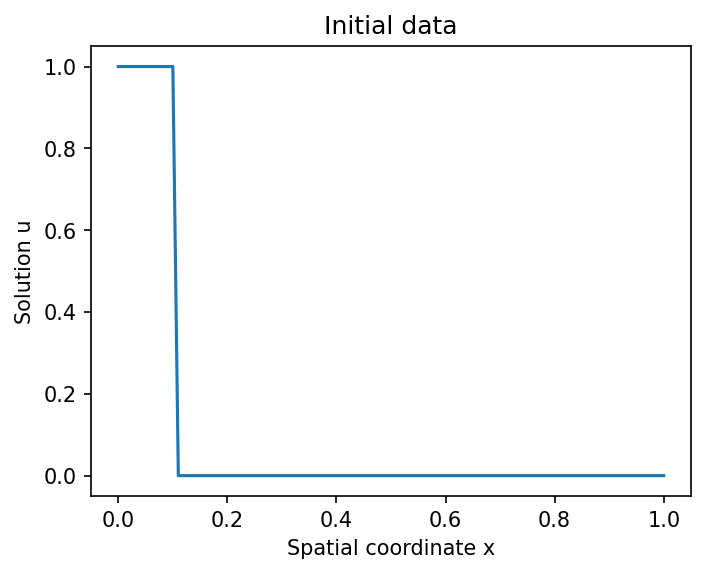

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def initialData( h ):

  # Initial solution profile
  # Input: grid size m
  # Output: initial condition u

  # spatial domain endpoints
  xL = 0
  xR = 1

  m = int(1 + (xR - xL) / h)                      # mesh size
  x = np.linspace(xL, xR, m).reshape((m, 1)) # grid points

  v = 1-np.heaviside(x-0.1,0)

  # Boundary conditions
  uL = v[0]
  uR = v[m-1]

  return v

v = initialData(0.01)
x = np.linspace(0,1,int(1+ 1/0.01)).reshape((int(1+ 1/0.01),1))
fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0,0,1,1])
ax.plot(x,v)

ax.set_title('Initial data')
ax.set_xlabel('Spatial coordinate x')
ax.set_ylabel('Solution u')


Solve the system.

In [31]:
hIn = 0.01
Tend = 1
dt = 0.01
nu = 0.01
sols = burgersModel( dt, Tend, hIn , nu)


Time step: 0
 k    f(xk)
 0  1.60e+02


/tmp/ipykernel_27059/989455296.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i,k] = (F[i] - F0[i]) / h


 1  1.37e+01
 2  1.50e-01
 3  1.67e-05
 4  8.94e-13
Time step: 1
 k    f(xk)
 0  1.67e+01
 1  2.16e-01
 2  3.83e-05
 3  2.55e-12
Time step: 2
 k    f(xk)
 0  5.43e+00
 1  2.51e-02
 2  4.06e-07
Time step: 3
 k    f(xk)
 0  3.20e+00
 1  7.74e-03
 2  4.41e-08
Time step: 4
 k    f(xk)
 0  2.33e+00
 1  4.05e-03
 2  9.36e-09
Time step: 5
 k    f(xk)
 0  1.87e+00
 1  2.54e-03
 2  4.06e-09
Time step: 6
 k    f(xk)
 0  1.58e+00
 1  1.78e-03
 2  1.86e-09
Time step: 7
 k    f(xk)
 0  1.38e+00
 1  1.35e-03
 2  1.19e-09
Time step: 8
 k    f(xk)
 0  1.24e+00
 1  1.07e-03
 2  6.88e-10
Time step: 9
 k    f(xk)
 0  1.14e+00
 1  8.80e-04
 2  5.27e-10
Time step: 10
 k    f(xk)
 0  1.05e+00
 1  7.47e-04
 2  3.50e-10
Time step: 11
 k    f(xk)
 0  9.85e-01
 1  6.47e-04
 2  2.92e-10
Time step: 12
 k    f(xk)
 0  9.30e-01
 1  5.72e-04
 2  2.14e-10
Time step: 13
 k    f(xk)
 0  8.84e-01
 1  5.13e-04
 2  1.87e-10
Time step: 14
 k    f(xk)
 0  8.46e-01
 1  4.65e-04
 2  1.47e-10
Time step: 15
 k    f(xk)
 0  8.13

Text(0, 0.5, 'u(x,t)')

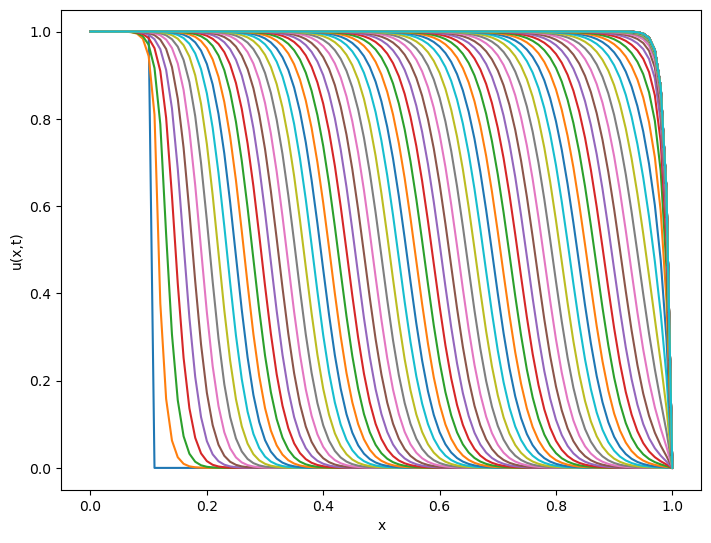

In [32]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)

fig=plt.figure()
ax=fig.add_axes([0.0,0.0,1.0,1.0])
for t in range(0, tPts):
  ax.plot(x,sols[:,t])
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

Text(0.5, 1.0, 'Solution to Burgers equation for $\\nu = 0.01$')

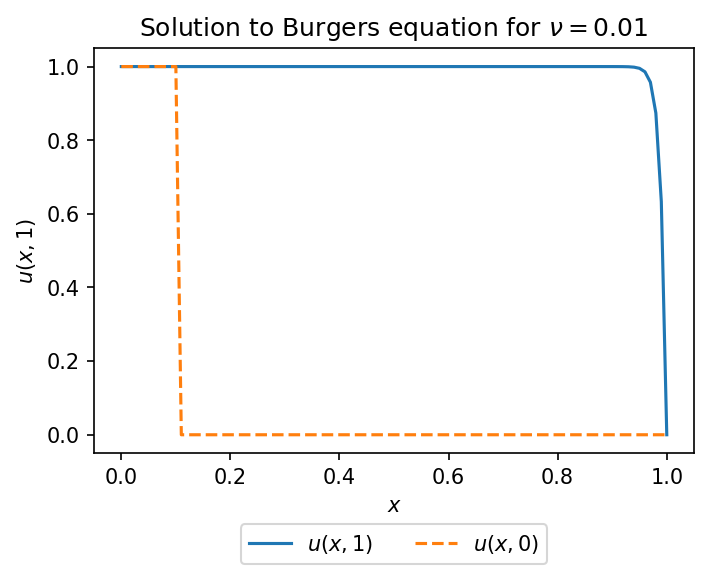

In [33]:
from matplotlib import pyplot as plt
import numpy as np
v = initialData(0.01)

fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0.0,0.0,1.0,1.0])
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)
ax.plot(x,sols[:,tPts], label="$u(x,1)$")
ax.plot(x,v,'--', label="$u(x,0)$")


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, ncol=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,1)$')
ax.set_title('Solution to Burgers equation for $\\nu = 0.01$')

In [34]:
from matplotlib import rc
rc('animation', html='jshtml')
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,6))
ax = plt.axes( )
plt.close()

def frame(w):
    ax.clear()
    global x,y,z
    x=np.linspace(0, 1, mPts)
    ax.set_xlabel('x')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylabel('u(x,t)')
    ax.set_ylim(0.0, 1.0)
    plot = ax.plot(x, sols[:,w])


In [35]:
anim = animation.FuncAnimation(fig, frame, frames=tPts, blit=False, repeat=True)

In [36]:
anim

(d) By tracking position of the midpoint of the wavefront over each time step, the approximate wavefront velocity can be calculated:

$$
v^k = \frac{x^k_{mid} - x^{k-1}_{mid} }{\Delta t},
$$

where,

$$
u(x_{mid}) = 0.5
$$


We have the sols for each time step and an x axis. We need to find the closes value to 0.5 for each time step and relate that to the x of the same index in the array.

In [37]:
umid = 0.5
xmid_index = np.zeros(len(sols[0,:]), int)
vmid = np.zeros(len(xmid_index) -1)
for k in range(0,len(sols[0,:])):
    solmid = abs(np.array(sols[:,k]) - umid)
    xmid_index[k] = np.argmin(solmid)
    if k > 0:
        vmid[k-1] = (x[xmid_index[k]] - x[xmid_index[k-1]]) / dt



Text(0.5, 1.0, "Approximate wavefront speed for the solution to Burgers' equation with $\\nu = 0.01$")

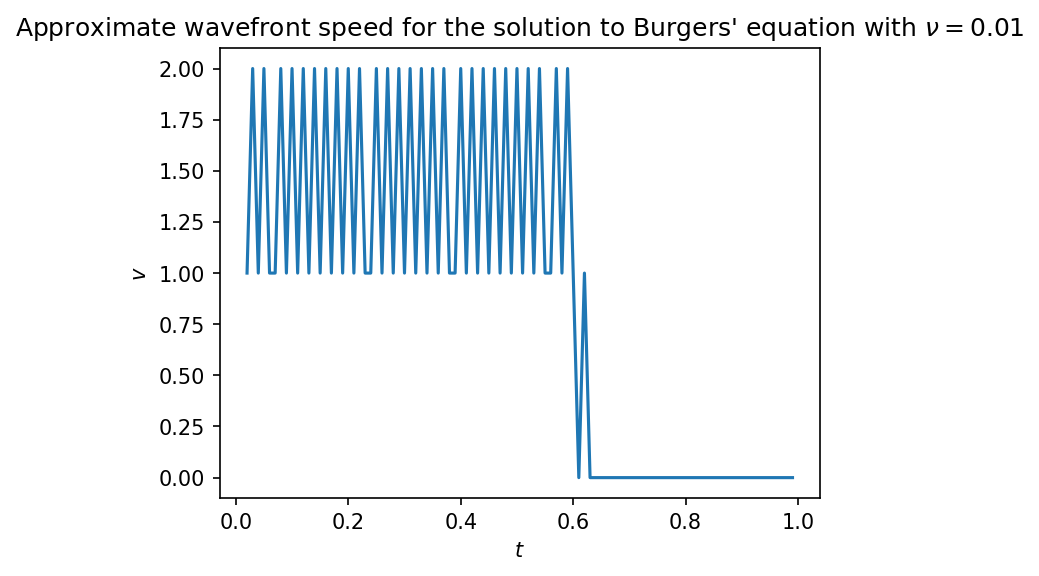

In [38]:
from matplotlib import pyplot as plt
import numpy as np

trange = np.linspace(0.01,1,100)

fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0.0,0.0,1.0,1.0])

ax.plot(trange[1:-1],vmid[1:-1])
ax.set_xlabel('$t$')
ax.set_ylabel('$v$')
ax.set_title('Approximate wavefront speed for the solution to Burgers\' equation with $\\nu = 0.01$')



In [39]:
umid = 0.5
#Values of u at all timesteps at the end of the domain
tindex = np.copy(sols[-2,:]) - umid
tmin = np.argmin(abs(tindex))
velocity = 1 / tmin
print(f'Time at which u(1,T) = 0.5 is {tmin}')
print(f'Wavefront speed is {velocity}')

Time at which u(1,T) = 0.5 is 63
Wavefront speed is 0.015873015873015872


(e) The discretisation of Burgers' equation can be modified: 


$$
F_i(\mathbf{U}) = \frac{U^k_i - U^{k-1}_i}{\Delta t} + U^k_i\left(\frac{U^k_i - U^k_{i-1}}{h}\right) - \nu\left(\frac{U^k_{i+1} - 2U^k_i + U^k_{i-1}}{h^2}\right),
$$

to use upwind differences for the convection term:
$$
F_i(\mathbf{U}) = \frac{U^k_i - U^{k-1}_i}{\Delta t} + U^k_i\left(\frac{U^k_{i+1} - U^k_{i}}{h}\right) - \nu\left(\frac{U^k_{i+1} - 2U^k_i + U^k_{i-1}}{h^2}\right),
$$


In [40]:
import numpy as np

def fun_burgers_upwind(uk, ukp, dt, h, nu):

  # Nonlinear residual function
  # Input: uk    -  vector U^k (dimension m x 1)
  #        ukp -  previous solution (dimension m x 1)
  #        dt   - time-step
  #        h    - spatial grid size
  #        nu    - kinematic viscosity
  #        ua    - left boundary value
  #        ub    - right boundary value
  # Output: f   - nonlinear functions evaluated at u

  m = ukp.size
  f = np.zeros( (m-2, 1) )
  ua = ukp[0]
  ub = ukp[m-1]

  # Difference equation at the left boundary
  f[0] = ( uk[0] - ukp[1] ) / dt + uk[0] * ( uk[1] - uk[0] ) / h - nu * ( uk[1] - 2*uk[0] + ua ) / h**2 

  # Difference equations at each internal node
  for i in range(1,m-3):
    f[i] = ( uk[i] - ukp[i] ) / dt + uk[i] * ( uk[i+1] - uk[i] ) / h - nu * ( uk[i+1] - 2*uk[i] + ukp[i-1] ) / h**2 

  # Difference equation at the right boundary
  f[m-3] = ( uk[m-3] - ukp[m-3] ) / dt + uk[m-3] * ( ub - uk[m-3] ) / h - nu * ( ub - 2*uk[m-3] + ukp[m-4] ) / h**2 

  return f

In [41]:
def burgersModel_upwind( dtIn, Tend, hIn , nu):

  # Implicit Euler in time, finite difference in space
  # numerical model for the Fisher Equation
  #  function sols = fisherModel( dtIn, nTimeSteps, mIn )
  # Input:  dtIn       - time step size
  #         nTimeSteps - number of time steps
  #         mIn        - grid dimension
  # Output: sols       - array of solution vectors u^k

  dt = dtIn   # time step size
  h = hIn # grid size
  m = int(1+ 1/h)     # dimension of spatial mesh for [X1,X2]
  n = m-2     # number of nonlinear equations (excluding boundary condition)
  nTimeSteps = int(Tend/dtIn)
  # Initial and boundary conditions
  uOld = initialData( h )
  u0 = np.zeros( (n,1) )
  
  # Create an array for the solutions in time
  sols = np.array(uOld)
  Its = 0

  # Time stepping loop
  for k in range( 0, nTimeSteps ):
    print('Time step: {0:1.0f}'.format(k))

    # Use previous time step as the Newton initial guess
    u0 = uOld[1:n+1]

    # Call the Newton solver
    u, It = myNewtonSys("fun_burgers_upwind", "fdJacobian", u0, 1e-6, 10, uOld, dt, h, nu)

    # Update the previous time step
    uOld[1:n+1] = u[0:n]

    # Store the solution vector
    sols = np.hstack((sols,uOld))
    #Track total iterations
    Its += It

  print(f'Total Newton Iterations = {Its}')
  return sols

In [42]:
hIn = 0.01
Tend = 1
dt = 0.01
nu = 0.01
solsupwind = burgersModel_upwind( dt, Tend, hIn , nu)

Time step: 0
 k    f(xk)
 0  3.63e+01


/tmp/ipykernel_27059/989455296.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J[i,k] = (F[i] - F0[i]) / h


 1  3.07e+00
 2  4.41e-02
 3  1.01e-05
 4  2.13e-13
Time step: 1
 k    f(xk)
 0  1.96e+01
 1  7.89e-01
 2  1.66e-03
 3  6.48e-09
Time step: 2
 k    f(xk)
 0  1.57e+01
 1  5.10e-01
 2  5.20e-04
 3  7.96e-10
Time step: 3
 k    f(xk)
 0  1.30e+01
 1  3.45e-01
 2  2.24e-04
 3  1.33e-10
Time step: 4
 k    f(xk)
 0  1.05e+01
 1  1.89e-01
 2  7.58e-05
 3  5.51e-12
Time step: 5
 k    f(xk)
 0  9.02e+00
 1  9.91e-02
 2  1.96e-05
 3  4.77e-13
Time step: 6
 k    f(xk)
 0  8.36e+00
 1  1.07e-01
 2  1.78e-05
 3  2.90e-13
Time step: 7
 k    f(xk)
 0  7.75e+00
 1  1.07e-01
 2  2.81e-05
 3  6.38e-13
Time step: 8
 k    f(xk)
 0  7.07e+00
 1  6.42e-02
 2  7.34e-06
 3  2.97e-13
Time step: 9
 k    f(xk)
 0  6.64e+00
 1  4.43e-02
 2  1.23e-06
 3  5.81e-14
Time step: 10
 k    f(xk)
 0  6.42e+00
 1  6.51e-02
 2  1.00e-05
 3  2.78e-13
Time step: 11
 k    f(xk)
 0  6.12e+00
 1  5.69e-02
 2  7.58e-06
 3  2.90e-13
Time step: 12
 k    f(xk)
 0  5.82e+00
 1  3.02e-02
 2  8.95e-07
Time step: 13
 k    f(xk)
 0  5.67

Text(0, 0.5, 'u(x,t)')

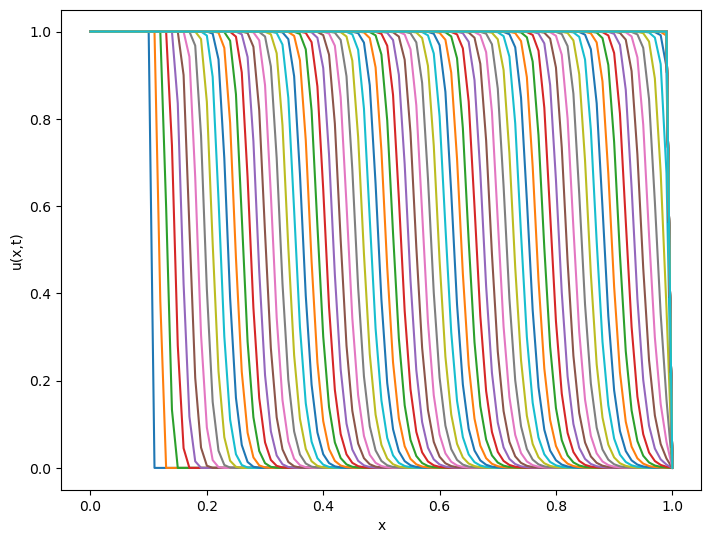

In [43]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)

fig=plt.figure()
ax=fig.add_axes([0.0,0.0,1.0,1.0])
for t in range(0, tPts):
  ax.plot(x,solsupwind[:,t])
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

Text(0.5, 1.0, 'Solution to Burgers equation for $\\nu = 0.01$')

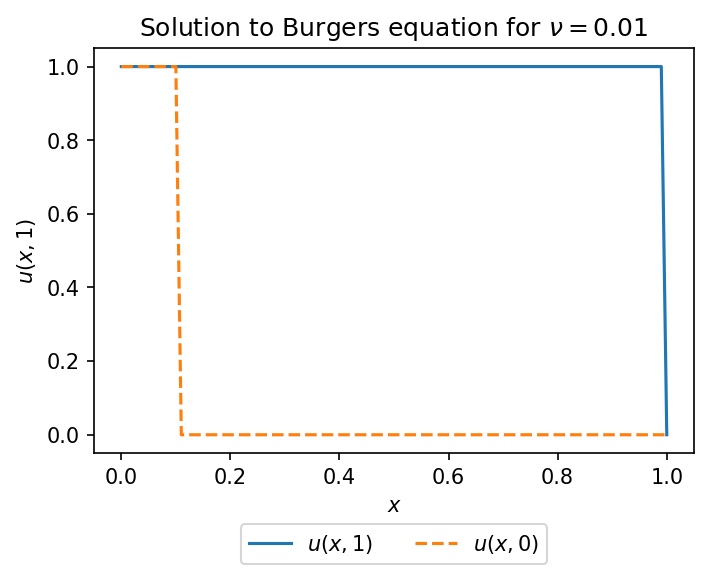

In [44]:
from matplotlib import pyplot as plt
import numpy as np
v = initialData(0.01)

fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0.0,0.0,1.0,1.0])
x=np.linspace(0, 1, int(1+1/hIn))
tPts = int(Tend/dt)
mPts = int(1 + 1/hIn)
ax.plot(x,solsupwind[:,tPts], label="$u(x,1)$")
ax.plot(x,v,'--', label="$u(x,0)$")


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, ncol=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,1)$')
ax.set_title('Solution to Burgers equation for $\\nu = 0.01$')

In [45]:
from matplotlib import rc
rc('animation', html='jshtml')
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,6))
ax = plt.axes( )
plt.close()

def frame(w):
    ax.clear()
    global x,y,z
    x=np.linspace(0, 1, mPts)
    ax.set_xlabel('x')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylabel('u(x,t)')
    ax.set_ylim(0.0, 1.0)
    plot = ax.plot(x, solsupwind[:,w])

In [46]:
anim2 = animation.FuncAnimation(fig, frame, frames=tPts, blit=False, repeat=True)

In [47]:
anim2

In [48]:
umid = 0.5
xmid_index = np.zeros(len(solsupwind[0,:]), int)
vmid = np.zeros(len(xmid_index) -1, float)
for k in range(0,len(solsupwind[0,:])):
    solmid = abs(np.array(solsupwind[:,k]) - umid)
    xmid_index[k] = np.argmin(solmid)
    if k > 0:
        vmid[k-1] = (x[xmid_index[k]] - x[xmid_index[k-1]]) / dt



Text(0.5, 1.0, "Approximate wavefront speed for the solution to Burgers' equation with $\\nu = 0.01$")

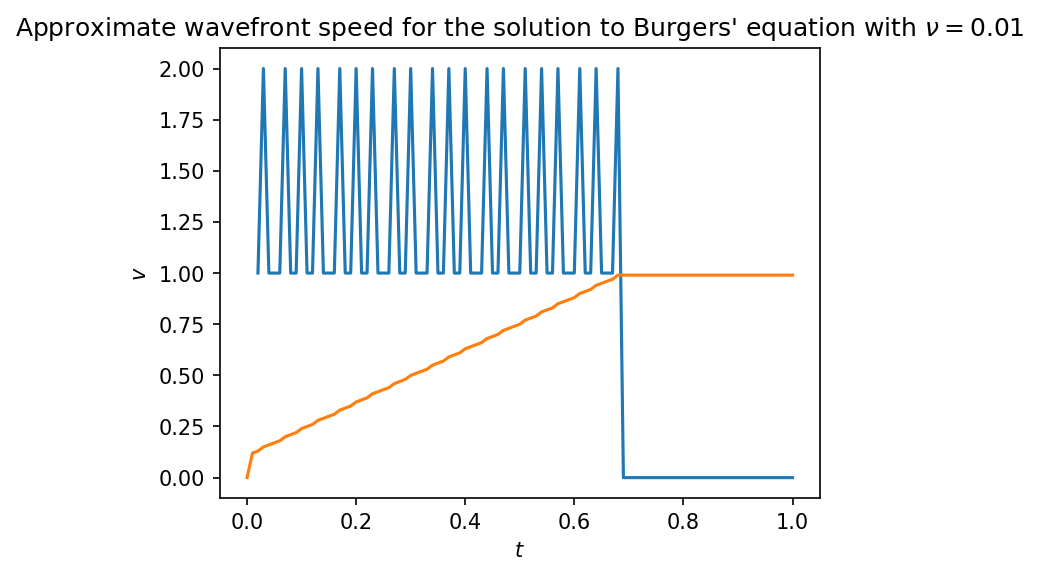

In [49]:
from matplotlib import pyplot as plt
import numpy as np

trange2 = np.linspace(0,1,101)

fig=plt.figure(figsize=(4, 3), dpi=150)
ax=fig.add_axes([0.0,0.0,1.0,1.0])

ax.plot(trange[1:],vmid[1:])
ax.plot(trange2,x[xmid_index])
ax.set_xlabel('$t$')
ax.set_ylabel('$v$')
ax.set_title('Approximate wavefront speed for the solution to Burgers\' equation with $\\nu = 0.01$')

Find the time when u(1,1) = 0.5

solsupwind[i,j]

i = t
j = x

In [50]:
#Velocity is:

#vel = 1/Ttravel
#Ttravel is the time at which u(1,Ttravel) = 0.5

#Extract x=1 for all time steps
#TODO: Issue with the initial condition and also even valued time steps

umid = 0.5
#Values of u at all timesteps at the end of the domain
tindex = np.copy(solsupwind[-2,:]) - umid
tmin = np.argmin(abs(tindex))
velocity = 1 / tmin
print(f'Time at which u(1,T) = 0.5 is {tmin}')
print(f'Wavefront speed is {velocity}')


Time at which u(1,T) = 0.5 is 68
Wavefront speed is 0.014705882352941176


/tmp/ipykernel_27059/2372244296.py:22: RuntimeWarning: overflow encountered in multiply
  un[1:-1] * dt / dx * (un[1:-1] - un[0:-2]) +
/tmp/ipykernel_27059/2372244296.py:22: RuntimeWarning: invalid value encountered in subtract
  un[1:-1] * dt / dx * (un[1:-1] - un[0:-2]) +
/tmp/ipykernel_27059/2372244296.py:21: RuntimeWarning: invalid value encountered in subtract
  u[1:-1] = (un[1:-1] -
/tmp/ipykernel_27059/2372244296.py:23: RuntimeWarning: invalid value encountered in subtract
  nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[0:-2]))
/tmp/ipykernel_27059/2372244296.py:23: RuntimeWarning: invalid value encountered in add
  nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[0:-2]))
/tmp/ipykernel_27059/2372244296.py:21: RuntimeWarning: invalid value encountered in add
  u[1:-1] = (un[1:-1] -


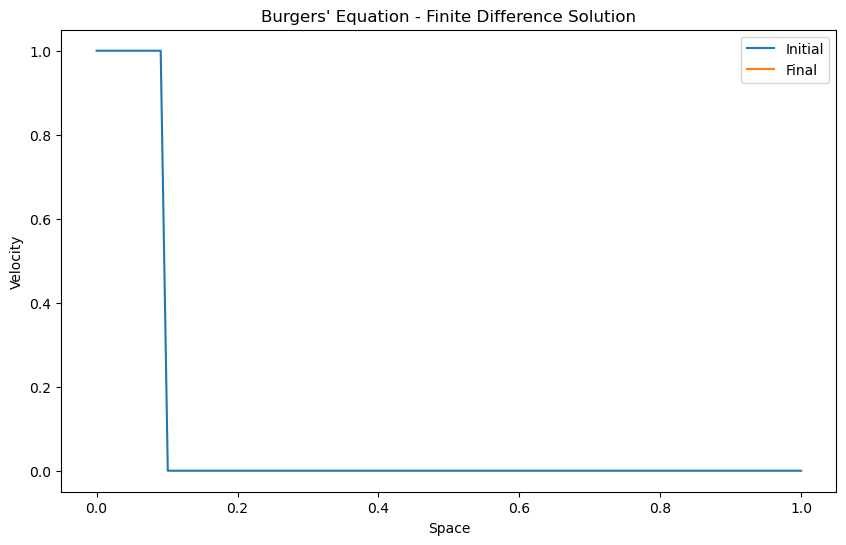

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def solve_burgers(u, nu, dx, dt, nt):
    """
    Solves the Burgers' equation using finite difference method.

    Parameters:
    u (numpy array): Initial velocity field.
    nu (float): Viscosity.
    dx (float): Spatial step size.
    dt (float): Time step size.
    nt (int): Number of time steps.
    
    Returns:
    numpy array: Velocity field after nt time steps.
    """
    for n in range(nt):
        un = u.copy()
        # Update all grid points
        u[1:-1] = (un[1:-1] - 
                   un[1:-1] * dt / dx * (un[1:-1] - un[0:-2]) + 
                   nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[0:-2]))
    
    return u

# Parameters

dx = 0.01  # spatial step size
nx = int(1/dx)  # number of spatial points
nt = 100  # number of time steps
dt = 0.01  # time step size
nu = 0.01  # viscosity

# Initial condition
x = np.linspace(0, 1, nx)
u_initial = 1-np.heaviside(x-0.1,0)

# Solve Burgers' equation
u_final = solve_burgers(u_initial.copy(), nu, dx, dt, nt)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, u_initial, label='Initial')
plt.plot(x, u_final, label='Final')
plt.title('Burgers\' Equation - Finite Difference Solution')
plt.xlabel('Space')
plt.ylabel('Velocity')
plt.legend()
plt.show()
